In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.sparse.linalg import splu, spsolve

from src.array import Array
from src.matrix_charge import Matrix as Matrix_charge
from src.matrix_discharge import Matrix as Matrix_discharge
from src.equation import Equation
from src.failure import Failure

In [2]:
length = 30
width = 2.0
seed = 0
val_cap = 0.01
time_step = 0.01
cond_ext = 100.0
mode_analysis = False
save_volts_profile = True

In [3]:
array = Array(length=length, mode_analysis=mode_analysis)
matrix_ch = Matrix_charge(matrix_init=None, array=array, val_cap=val_cap, time_step=time_step)
matrix_dch = Matrix_discharge(matrix_init=None, array=array, cond_ext=cond_ext, val_cap=val_cap, time_step=time_step)
equation = Equation(array=array, matrix_ch=matrix_ch, matrix_dch=matrix_dch)
failure = Failure(array=array, matrix_ch=matrix_ch, matrix_dch=matrix_dch, equation=equation, width=width, seed=seed, save_volts_profile=save_volts_profile)

In [4]:
solve_r = equation.solve_r_amd

def run_charge_cycle_first(duration_cycle: int) -> bool:
    solve = equation.solve_true_init_ch
    break_edge = failure.break_edge_init_ch
    solve(); break_edge()  # t=0 fresh start

    solve = equation.solve_ch
    break_edge = failure.break_edge_ch
    for _ in range(duration_cycle - 1):
        if not solve_r():
            return False
        solve(); break_edge()
    return True

def run_charge_cycle_from_dch(duration_cycle: int) -> bool:
    solve = equation.solve_init_ch
    break_edge = failure.break_edge_ch
    solve(); break_edge()  # t=0 after D→C (caps nonzero)

    solve = equation.solve_ch
    break_edge = failure.break_edge_ch
    for _ in range(duration_cycle - 1):
        if not solve_r():
            return False
        solve(); break_edge()
    return True

def run_discharge_cycle(duration_cycle: int) -> bool:
    solve = equation.solve_init_dch
    break_edge = failure.break_edge_dch
    solve(); break_edge()  # t=0 for C→D

    solve = equation.solve_dch
    break_edge = failure.break_edge_dch
    for _ in range(duration_cycle - 1):
        if not solve_r():
            return False
        solve(); break_edge()
    return True


In [5]:
duration_charge = 15
duration_discharge = 15

if run_charge_cycle_first(duration_charge):
    while run_discharge_cycle(duration_discharge) and run_charge_cycle_from_dch(duration_charge):
        pass


In [6]:
def count_broken_per_cycle(failure, duration_charge: int, duration_discharge: int):
    t = np.asarray(failure.idxs_time_edge_broken, dtype=np.int64)
    if t.size == 0:
        return np.array([], int), np.array([], int)
    period = duration_charge + duration_discharge
    cyc = t // period
    is_ch = (t % period) < duration_charge
    ncyc = int(cyc.max()) + 1
    ch = np.zeros(ncyc, dtype=int)
    dch = np.zeros(ncyc, dtype=int)
    for c, f in zip(cyc, is_ch):
        (ch if f else dch)[c] += 1
    return ch, dch
count_broken_per_cycle(failure, duration_charge, duration_discharge)

(array([15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15]),
 array([0, 0, 3, 0, 1, 0, 1, 2, 3, 4, 0, 5, 2, 6, 2, 1]))

In [7]:
sum([0, 0, 3, 0, 1, 0, 1, 2, 3, 4, 0, 5, 2, 6, 2, 1])

30

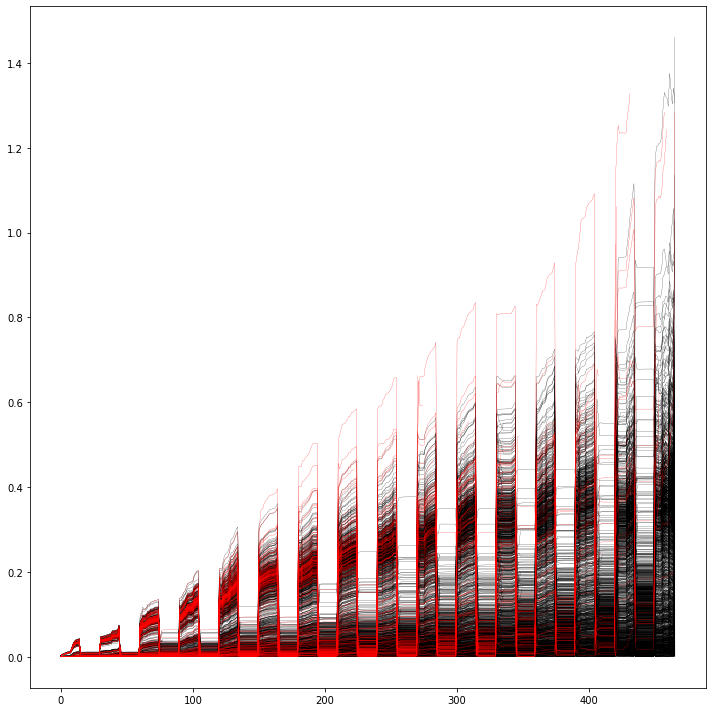

In [8]:
unsigned: bool = True
profile: np.ndarray = np.array(failure.volts_edge_profile, dtype=np.float64).transpose() # [edge, time]
if unsigned: np.abs(profile, out=profile)
idxs_edge_broken: np.ndarray = np.array(failure.idxs_edge_broken, dtype=np.int32)
num_edge, num_time = profile.shape

for idx_time, idx_edge_broken in zip(failure.idxs_time_edge_broken, idxs_edge_broken):
    profile[idx_edge_broken, (idx_time + 1):] = np.nan

size_obj = 0.2
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=72)

ax.scatter(0, profile[idxs_edge_broken[0], 0], c="red", s=size_obj, zorder=num_edge)
for idx_edge, votls_per_edge in enumerate(profile):
    if idx_edge in idxs_edge_broken:
        ax.plot(range(num_time), votls_per_edge, c="red", lw=size_obj, zorder=num_edge)
    else:
        ax.plot(range(num_time), votls_per_edge, c="black", lw=size_obj)

# ax.set_xlim(2, 11)
# ax.set_ylim(-0.01, 0.01)

plt.tight_layout()
plt.show()


In [9]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

from resistor_capacitor.breakdown import breakdown
from analysis.rcc_src_tbc.draw import Draw


In [10]:
np.array_equal(list(set(failure.idxs_edge_broken)), list(set(breakdown(length, width, seed, val_cap, time_step)[-1].idxs_edge_broken)))

False

In [11]:
len(breakdown(length, width, seed, val_cap, time_step)[-1].idxs_edge_broken), len(failure.idxs_edge_broken)

(433, 270)

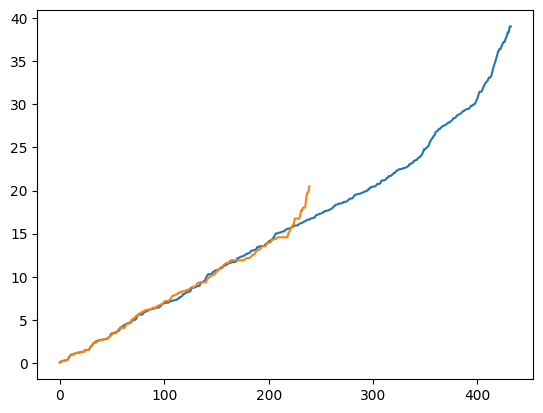

In [12]:
plt.plot(breakdown(length, width, seed, val_cap, time_step)[-1].volts_ext)
plt.plot(np.array(failure.volts_ext)[~np.isnan(failure.volts_ext)])

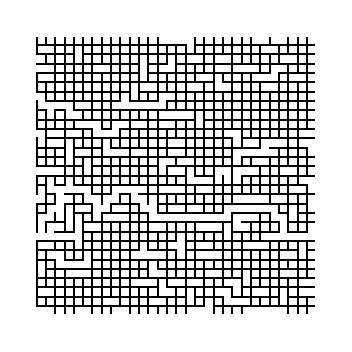

In [13]:
draw = Draw(array, matrix_ch, equation, failure)
draw.graph_initialize(
    figsize=(5, 5), dpi=72, size_edge=2, pad_inches=-0.7, 
    transparent=False, save=False, show=True,
)
draw.graph_specific(failure.idxs_edge_broken, 0)

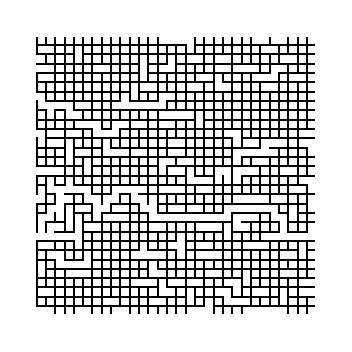

In [14]:
draw = Draw(*breakdown(length, width, seed, val_cap, time_step))
draw.graph_initialize(
    figsize=(5, 5), dpi=72, size_edge=2, pad_inches=-0.7, 
    transparent=False, save=False, show=True,
)
draw.graph_specific(failure.idxs_edge_broken, 0)

---

In [15]:
# failure_rcc.idxs_edge_broken, failure_rcc.volts_ext

In [16]:
# # breakdown simulation
# # 1st bond breaking [t=0]
# solve = equation.solve_init
# break_edge = failure.break_edge_init
# solve()
# break_edge()

# # 2nd ~ (length)th bond breaking [t=1 ~ t=(length-1)]
# solve = equation.solve
# solve_r = equation.solve_r_mmd
# break_edge = failure.break_edge
# for _ in range(array.length - 1):
#     solve_r()
#     solve()
#     break_edge()

# # (length+1)th ~ (macroscopic failure) bond breaking [t=(length) ~ (total number of broken bonds-1)]
# solve_r = equation.solve_r_amd
# while solve_r():
#     solve()
#     break_edge()